# Project 4

### Goals/notes
* Focus on Uganda, families, 2011

In [1]:
!pip install CFEDemands --upgrade
!pip install ConsumerDemands
!pip install oauth2client
!pip install eep153_tools
!pip install gnupg
#!pip install dvc

  Using cached CFEDemands-0.4.1-py2.py3-none-any.whl (39 kB)
  Using cached ConsumerDemands-0.3.dev0-py2.py3-none-any.whl (12 kB)
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)
  Using cached eep153_tools-0.11-py2.py3-none-any.whl (4.4 kB)
Processing ./.cache/pip/wheels/20/7e/30/7d702acd6a1e89911301cd9dbf9cb9870ca80c0e64bc2cde23/gnupg-2.3.1-py3-none-any.whl


In [2]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Data

In [3]:
InputFiles = {'Expenditures':('1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk','Expenditures'),
              'Consumption':('1RT5AfbZbWx-CmNaOHLp7aD9qEjgjiBv8lZmPexuKEWg','Consumption'),
              'HH Characteristics':('1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk','HH Characteristics'),
              'FCT': ('1DjpLsyhUbQ-giGcTS_GMrDuW_wG3VDrYH1p-FanKxxs','Codes')}

#### Function to read in sheets:

In [4]:
def get_clean_sheet(key,sheet=None):
    dfs = read_sheets(key)
    if sheet is not None:
        df = dfs[sheet]
    else:
        df = dfs.values()[0] 
    df.columns = [c.strip() for c in df.columns.tolist()]
    df = df.loc[:,~df.columns.duplicated(keep='first')]   
    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)
    df = df.loc[~df.index.duplicated(), :]
    return df

#### Expenditure Table

In [5]:
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['j','t','m'])
x.columns.name = 'i'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)



# We only want data from 2011, as that is our focus year:
x_2011 = x[x.index.isin([2011], level=1)]

# Log of expenditure table (x); 
# log table (y) will be used for later estimation:
y_2011 = np.log(x_2011)

Key available for students@eep153.iam.gserviceaccount.com.


#### Household Characteristics Table

In [6]:
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['j','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))



z_2011 = z[z.index.isin([2011], level=1)]

Key available for students@eep153.iam.gserviceaccount.com.


#### Consumption Quantities Table

In [7]:
q = get_clean_sheet(InputFiles['Consumption'][0],
                    sheet=InputFiles['Consumption'][1])

if 'm' not in q.columns:
    q['m'] = 1

q = q.set_index(['j','t','m','u'])
q.columns.name = 'i'

q = q.apply(lambda x: pd.to_numeric(x,errors='coerce'))
q = q.replace(0,np.nan)



q_2011 = q[q.index.isin([2011], level=1)]

Key available for students@eep153.iam.gserviceaccount.com.


#### Food Conversion Table

In [8]:
fct = get_clean_sheet(InputFiles['FCT'][0],sheet=InputFiles['FCT'][1])

fct.index.name = 'i'
foods = fct['Food description']
fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))
fct['Food description'] = foods
fct = fct.set_index('Food description')

Key available for students@eep153.iam.gserviceaccount.com.


## Population

* Compare households **in the same income bracket** with **different numbers of children** to understand how demand of nutrients changes per child added to a household
    - We don’t have income levels, we only have household expenditures
    - Does this cause a problem, like if a family of 6 in one income bracket has a similar household expenditure to a family of 6 in a higher income bracket???
    - Be really picky about households, make sure they’re actually very similar
* We might want to take **a couple households with the same number of children each and find an average** (like an average for a household with 2 children, an average for a household with 5 children) and compare averages


Ideas:
* Definitely create filters
    - Children TOTAL filter
    - Adult TOTAL filter
    - Doesn't matter what the breakdown is, as long as children=children and adult=adult for every household in that particular dataset
    - We can call any combo of age breakdowns with this system
* Look up income data in a separate place? Will it even be household specific tho, to the same household id's that we have here?

In [9]:
# Make a column with total count of children, and one with total count of adults:
z_count = z_2011
z_count["Children"], z_count["Adults"] = [(z_2011["M 0-3"] + z_2011["F 0-3"] + 
                                           z_2011["M 4-8"] + z_2011["F 4-8"] +
                                           z_2011["M 9-13"] + z_2011["F 9-13"] +
                                           z_2011["M 14-18"] + z_2011["F 14-18"]),
                                          (z_2011["M 19-30"] + z_2011["F 19-30"] + 
                                           z_2011["M 31-50"] + z_2011["F 31-50"] +
                                           z_2011["M 51+"] + z_2011["F 51+"])]

/tmp/ipykernel_25/1615739697.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_count["Children"], z_count["Adults"] = [(z_2011["M 0-3"] + z_2011["F 0-3"] +


In [10]:
z_count

,,k,M 0-3,M 4-8,M 9-13,M 14-18,M 19-30,M 31-50,M 51+,F 0-3,F 4-8,F 9-13,F 14-18,F 19-30,F 31-50,F 51+,Children,Adults
j,t,m,,,,,,,,,,,,,,,,
1013000201,2011,1,0,1,2,1,0,0,0,0,0,0,1,1,1,0,5,2
1013000202,2011,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,2,1
1013000204,2011,1,0,0,0,0,0,1,0,1,2,0,0,0,1,0,3,2
1013000206,2011,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3
1013000210,2011,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3010730012030203,2011,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,2
3010730016100203,2011,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,2
3010830020020503,2011,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,3


In [12]:
# Manually looking at households WITH children and seeing what child/adult breakdowns we're interested in:
filter_kid = z_count["Children"]!=0
z_kids = z_count[filter_kid]
df_analyze = z_kids[['Children', 'Adults']]

# Uncomment to look at it again:
# df_analyze.head(60)

Now what dataframes should we create to focus on? We can do any combination of adults and children in a house;
* _**Focus on houses with just 2 adults**_, as a control measure (and because it's overwhelmingly common)
    - But that could be a bit biased; there are some households with many adults, perhaps multi-family households. These could be more likely to be low-income (living together to support each other), and we are just omitting them from the get-go. Something to note !
* Look at the difference from 2 kids (1 dataset) to 3 (2 datasets), 3 kids to 4 (3 datasets)... perhaps 4 to 5 (4 datasets) as well. Yeah 4 dataframes is manageable
* Do analysis regardless of income level? Because we don't know it? Get an average 

In [18]:
# 0 kids filter:
filter0 = z_count["Children"]==0

# 1 kid filter:
filter1 = z_count["Children"]==1

# 2 kids filter:
filter2 = z_count["Children"]==2

# 3 kids filter:
filter3 = z_count["Children"]==3

# 4 kids filter:
filter4 = z_count["Children"]==4

# 5 kids filter:
filter5 = z_count["Children"]==5

# 6 kids filter:
filter6 = z_count["Children"]==6


# Only 2 adults filter:
filter_adult = z_count["Adults"]==2

In [19]:
# Use filters in different combinations to get 4 different dataframes:

zero_kid = z_count[filter0 & filter_adult]

one_kid = z_count[filter1 & filter_adult]

two_kid = z_count[filter2 & filter_adult]

three_kid = z_count[filter3 & filter_adult]

four_kid = z_count[filter4 & filter_adult]

five_kid = z_count[filter5 & filter_adult]

six_kid = z_count[filter6 & filter_adult]

In [20]:
# Function to get household id numbers from any dataframe
def get_ids(df):
    multiple_list = list(df.index.values)
    return [i[0] for i in multiple_list]


# Function to get total expenditures of any dataframe
def get_total_exp(df):
    return (df.sum(axis = 1)).to_frame('Total Exp').droplevel(level=[1,2])
# get rid of droplevel ^ if that ends up being a matching problem


# Function to get a total average expenditure for all households, for a dataframe like that ^
def average_exp(df):
    list_exp = df['Total Exp'].tolist()
    return sum(list_exp)/len(list_exp)

### 0 children, 2 adult households:

In [21]:
# Pull a list of household ID's from the initial family breakdowns:
# (we will use a more refined ID list once we know what households to drop for having all NaN expenditure values)
zero_kid_rough_ids = get_ids(zero_kid)

# Getting expenditure dataframe just for this family breakdown, and dropping the ones with no expenditure data:
zero_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(zero_kid_rough_ids)]).dropna(axis=0, how='all')

# TOTAL sum expenditure per household:
zero_kid_total_x = get_total_exp(zero_kid_x)

zero_kid_ids = get_ids(zero_kid_x)

print('Number of 0 child/2 adult households WITH expenditure data: ', len(zero_kid_x))

Number of 0 child/2 adult households WITH expenditure data:  80


### 1 child, 2 adult households:

In [22]:
# Repeat above for each household breakdown:
one_kid_rough_ids = get_ids(one_kid)
one_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(one_kid_rough_ids)]).dropna(axis=0, how='all')
one_kid_total_x = get_total_exp(one_kid_x)
one_kid_ids = get_ids(one_kid_x)

print('Number of 1 child/2 adult households WITH expenditure data: ', len(one_kid_x))

Number of 1 child/2 adult households WITH expenditure data:  142


### 2 child, 2 adult households:

In [23]:
two_kid_rough_ids = get_ids(two_kid)
two_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(two_kid_rough_ids)]).dropna(axis=0, how='all')
two_kid_total_x = get_total_exp(two_kid_x)
two_kid_ids = get_ids(two_kid_x)

print('Number of 2 child/2 adult households WITH expenditure data: ', len(two_kid_x))

Number of 2 child/2 adult households WITH expenditure data:  190


### 3 child, 2 adult households:

In [24]:
three_kid_rough_ids = get_ids(three_kid)
three_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(three_kid_rough_ids)]).dropna(axis=0, how='all')
three_kid_total_x = get_total_exp(three_kid_x)
three_kid_ids = get_ids(three_kid_x)

print('Number of 3 child/2 adult households WITH expenditure data: ', len(three_kid_x))

Number of 3 child/2 adult households WITH expenditure data:  226


### 4 child, 2 adult households:

In [25]:
four_kid_rough_ids = get_ids(four_kid)
four_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(four_kid_rough_ids)]).dropna(axis=0, how='all')
four_kid_total_x = get_total_exp(four_kid_x)
four_kid_ids = get_ids(four_kid_x)

print('Number of 4 child/2 adult households WITH expenditure data: ', len(four_kid_x))

Number of 4 child/2 adult households WITH expenditure data:  216


### 5 child, 2 adult households:

In [26]:
five_kid_rough_ids = get_ids(five_kid)
five_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(five_kid_rough_ids)]).dropna(axis=0, how='all')
five_kid_total_x = get_total_exp(five_kid_x)
five_kid_ids = get_ids(five_kid_x)

print('Number of 5 child/2 adult households WITH expenditure data: ', len(five_kid_x))

Number of 5 child/2 adult households WITH expenditure data:  184


### 6 child, 2 adult households:

In [27]:
six_kid_rough_ids = get_ids(six_kid)
six_kid_x = (x_2011[x_2011.index.get_level_values('j').isin(six_kid_rough_ids)]).dropna(axis=0, how='all')
six_kid_total_x = get_total_exp(six_kid_x)
six_kid_ids = get_ids(six_kid_x)

print('Number of 6 child/2 adult households WITH expenditure data: ', len(six_kid_x))

Number of 6 child/2 adult households WITH expenditure data:  108


Now income? or no?
* If we take the average of each dataframe's expenditures, we'll get a rough picture of how expenditures increase, and because we can't get income data, taking an average of ALL households with this child breakdown will give us a rough picture still

In [58]:
exp_data = {'Num Kids':[0, 1, 2, 3, 4, 5, 6],
        'Avg Expenditure (UGX)':[average_exp(zero_kid_total_x), average_exp(one_kid_total_x), average_exp(two_kid_total_x), average_exp(three_kid_total_x), average_exp(four_kid_total_x), average_exp(five_kid_total_x), average_exp(six_kid_total_x)]}

exp_table = pd.DataFrame(exp_data)

In [59]:
exp_table

,Num Kids,Avg Expenditure (UGX)
0,0,21588.062500
1,1,27643.239437
2,2,26814.578947
3,3,25776.360619
4,4,26222.893519
5,5,29320.538043
6,6,30356.111111


In [60]:
# Conversion for picturing it better: 
# 1 UGX = 0.000282670 USD

exp_table['Avg Expenditure (USD)'] = exp_table['Avg Expenditure (UGX)']*0.000282413

### Questions:
* Is this expenditure data for 1 day?
* Look at these conversions:

In [61]:
exp_table

,Num Kids,Avg Expenditure (UGX),Avg Expenditure (USD)
0,0,21588.062500,6.096749
1,1,27643.239437,7.806810
2,2,26814.578947,7.572786
3,3,25776.360619,7.279579
4,4,26222.893519,7.405686
5,5,29320.538043,8.280501
6,6,30356.111111,8.572960


## Picturing Average Expenditure per __________(?)

Text(0, 0.5, 'Average Household Expenditure (in UGX)')

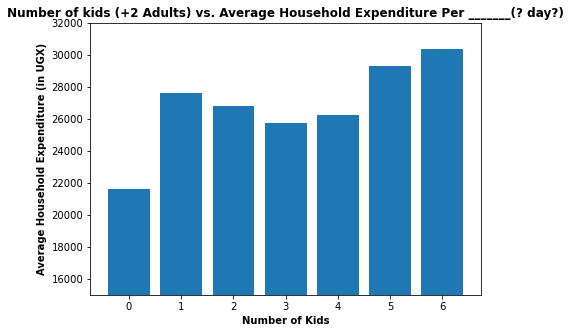

In [90]:
num_kids = exp_table['Num Kids'].to_list()
exp = exp_table['Avg Expenditure (UGX)'].to_list()
 
# Figure Size
fig, ax = plt.subplots(figsize =(7, 5))
 
# Horizontal Bar Plot
ax.bar(num_kids, exp)

ax.set_title('Number of kids (+2 Adults) vs. Average Household Expenditure Per _______(? day?)', fontweight='bold', fontsize=12)

ax.set_ylim([15000, 32000])

plt.xlabel('Number of Kids', fontweight='bold')
plt.ylabel('Average Household Expenditure (in UGX)', fontweight='bold')


In [20]:
# Use the j column of ID numbers to cross reference with the expenditure dataframe
# beans, maize, sweet bananas



## Estimate Demand System

In [91]:
# fix this:

zero_kid_z = (z_2011[z_2011.index.get_level_values('j').isin(zero_kid_ids)]).drop(['Children', 'Adults'], axis=1)
zero_kid_y = np.log(zero_kid_x)

In [95]:
# Create reduced form
import cfe

# help; fix what you use for y and z so you don't get this error:
# "assert m>n, "Fewer rows than columns.  Consider passing the transpose.""
result = cfe.Result(y=y_2011, z=z)

In [96]:
# run this to be able to run the next few lines:
result.get_reduced_form()

/opt/conda/lib/python3.9/site-packages/cfe/estimation.py:425: UserWarning: No variation in: (2011, 1)
  warnings.warn("No variation in: %s" % str(constant))


### Delta Values

In [97]:
result.delta.to_dataframe().unstack('k')

delta                                          \
k                        M 0-3     M 4-8    M 9-13   M 14-18   M 19-30   
i                                                                        
avocado               0.097390 -0.000298 -0.002529  0.024816  0.062356   
beans dry            -0.033781  0.046620  0.026822  0.123469  0.084657   
beef                  0.003358  0.020780  0.057455  0.082446  0.126969   
bread                 0.027542 -0.050078  0.035270 -0.002306  0.139526   
cabbages             -0.071833 -0.028588  0.018519  0.055541 -0.009824   
cassava fresh        -0.079663  0.071544  0.177111  0.087887  0.028489   
cooking oil          -0.071990 -0.041351 -0.010096  0.064656  0.186663   
dry/smoked fish      -0.150526  0.053474  0.049041  0.106142  0.126685   
egg plant            -0.084193 -0.052242  0.143536 -0.039920  0.140829   
eggs                 -0.019230 -0.002483 -0.102354 -0.001265  0.097308   
fresh fish            0.009262  0.094510  0.018288  0.044491  0.055314   
fresh milk            0.011238  0.005969 -0.006664 -0.017957  0.153407   
green pepper          0.017439 -0.009087  0.011228 -0.163656  0.095611   
ground nuts pounded   0.022274  0.030899 -0.149010 -0.001283 -0.023383   
irish potatoes        0.034765  0.102072  0.025799  0.159486 -0.014136   
maize flour           0.025299  0.075663  0.063105  0.130485  0.056715   
matooke_1            -0.074868  0.003366  0.077181  0.014564  0.111074   
onions               -0.020335 -0.030890 -0.018953  0.061176  0.093675   
passion fruits       -0.108469 -0.270940  0.155670 -0.061872 -0.002865   
pineapple             0.126161  0.136645  0.207146  0.140814  0.103457   
rice                  0.028396  0.081688  0.097083  0.077044  0.140990   
salt                  0.044037  0.056258  0.070997  0.064071  0.054070   
soda                  0.098761 -0.141898  0.099117  0.020529  0.006740   
sugar                 0.035054  0.057901  0.000693  0.066626  0.103477   
sweet bananas         0.042689 -0.201358 -0.051724 -0.128505  0.009964   
sweet potatoes fresh  0.170890  0.129987  0.127102  0.077111  0.036211   
tea                  -0.019471 -0.000083  0.014483  0.029646  0.146907   
tomatoes             -0.069173 -0.020040  0.002149  0.085621  0.126614   

                                                                        \
k                      M 31-50     M 51+     F 0-3     F 4-8    F 9-13   
i                                                                        
avocado               0.394081  0.225880  0.310472 -0.150028  0.003038   
beans dry             0.142313  0.232470 -0.002447  0.095900  0.083344   
beef                  0.171900  0.112030  0.042437  0.056436  0.079270   
bread                 0.367625  0.145779  0.005797  0.031808  0.080250   
cabbages              0.084263  0.042847  0.047824  0.001117  0.031828   
cassava fresh        -0.038353 -0.080616  0.042720  0.134190  0.116610   
cooking oil           0.148287 -0.020549 -0.034874  0.006245  0.036533   
dry/smoked fish       0.137609  0.071978  0.019783  0.107507  0.073289   
egg plant             0.198747  0.252701  0.049404  0.024176  0.047999   
eggs                  0.270351  0.150229  0.060682  0.055040  0.035340   
fresh fish            0.041523  0.172718  0.035145  0.063888  0.040449   
fresh milk            0.084728  0.054161  0.168125  0.049153 -0.013233   
green pepper          0.242125  0.184443 -0.035037 -0.098917 -0.200786   
ground nuts pounded   0.183803  0.227503 -0.041558  0.075903  0.039010   
irish potatoes       -0.009935  0.046919  0.077425 -0.039557  0.074755   
maize flour           0.189617  0.117059  0.018240  0.127268  0.125826   
matooke_1             0.121637  0.224531  0.025432  0.034911  0.180191   
onions                0.132432  0.063947 -0.048846  0.003891  0.057701   
passion fruits       -0.063724  0.175797  0.202256 -0.240650  0.065247   
pineapple            -0.135539 -0.172197  0.064227 -0.117736  0.119025   
rice                  0.1678

### Alpha Values

In [98]:
result.a.to_dataframe().unstack('i')

a                                                        \
i        avocado beans dry      beef     bread  cabbages cassava fresh   
t    m                                                                   
2005 1       NaN       NaN       NaN       NaN       NaN           NaN   
2009 1       NaN       NaN       NaN       NaN       NaN           NaN   
2010 1       NaN       NaN       NaN       NaN       NaN           NaN   
2011 1  6.287261  7.504387  8.428211  7.353705  6.699709      7.424376   

                                                        ...                 \
i      cooking oil dry/smoked fish egg plant      eggs  ... passion fruits   
t    m                                                  ...                  
2005 1         NaN             NaN       NaN       NaN  ...            NaN   
2009 1         NaN             NaN       NaN       NaN  ...            NaN   
2010 1         NaN             NaN       NaN       NaN  ...            NaN   
2011 1    6.899348        7.783114  5.971758  7.118171  ...       7.187871   

                                                                        \
i      pineapple      rice      salt      soda     sugar sweet bananas   
t    m                                                                   
2005 1       NaN       NaN       NaN       NaN       NaN           NaN   
2009 1       NaN       NaN       NaN       NaN       NaN           NaN   
2010 1       NaN       NaN       NaN       NaN       NaN           NaN   
2011 1  7.000679  7.820732  5.171825  7.722783  7.523932      7.144273   

                                                 
i      sweet potatoes fresh       tea  tomatoes  
t    m                                           
2005 1                  NaN       NaN       NaN  
2009 1                  NaN       NaN       NaN  
2010 1                  NaN       NaN       NaN  
2011 1             7.454155  4.941079  6.549808  

[4 rows x 28 columns]

### Beta Values

In [99]:
result.get_beta(as_df=True)

i
avocado                 0.449754
beans dry               0.246781
beef                    0.395557
bread                   0.554619
cabbages                0.381979
cassava fresh           0.228659
cooking oil             0.542915
dry/smoked fish         0.514294
egg plant               0.319895
eggs                    0.338717
fresh fish              0.416980
fresh milk              0.439894
green pepper            0.413669
ground nuts pounded     0.247551
irish potatoes          0.301860
maize flour             0.252947
matooke_1               0.314173
onions                  0.415573
passion fruits          0.593187
pineapple               0.418225
rice                    0.378356
salt                    0.133831
soda                    0.455573
sugar                   0.364103
sweet bananas           0.561489
sweet potatoes fresh    0.178698
tea                     0.216259
tomatoes                0.461308
Name: beta, dtype: float64

## Nutritional Adequacy Stuff

Note: All this code was written by someone now in another group: do we want to rewrite?? Not sure. Yes I might

*Deliverables:*
* **[A] Construct Nutrient System:** If you can describe quantities demanded as a function of prices, budgets, and household characteristics, and map quantities into nutrients, then you can also describe a system of nutrients as a function of the same variables

* **[A] Nutritional challenges & Policy Goal:** Compare predicted nutrition to recommended nutrition. Establish some criteria for deciding what the biggest nutritional challenges are for this population. For example, what share of households is Calorie deficient? Is protein deficient? Is Vitamin A deficient? Note that different criteria are possible, and there is no one “right” criterion. Characterize the nutritional challenges you observe in your data, and construct a policy goal to address some of these challenges (e.g., reduce the proportion of households that are protein deficient by half). 


In [13]:
foods = result.i.to_dataframe()
nutrients = fct[fct.index.isin(list(foods.index.values))]
q_items = q.loc[:,list(foods.index.values)]
q_items['Sum'] = q_items.sum(axis=1)
q_items = q_items[q_items['Sum']>0]
q_items = q_items.drop('Sum',axis=1)

In [14]:
diet_req = pd.read_csv("dietary_req.csv").drop(['Source'],axis=1)
dietreq = diet_req.set_index('Nutrition')
dietreq.iloc[len(dietreq)-1,:] = dietreq.iloc[len(dietreq)-1,:] * -1
diet_req = diet_req[diet_req['Nutrition'].isin(['Energy','Protein','Calcium, Ca','Iron, Fe', 'Magnesium, Mg','Vitamin A, RAE','Vitamin B-12','Vitamin B-6','Vitamin C, total ascorbic acid','Zinc, Zn','Vitamin E (alpha-tocopherol)'])]

In [15]:
# Definition functions 

def return_household(row):
    household = np.array([])
    for j in range(len(row)):
        if row[j] == 1:
            if (row.index[j] != 'M 0-3') & (row.index[j] != 'F 0-3'):
                household = np.append(household,row.index[j])
    return household

def return_nutrition(household):
    nut_pd = pd.DataFrame(np.array(np.zeros(len(diet_req['Nutrition']))),index=diet_req['Nutrition'])
    for i in range(len(household)): 
        req = diet_req.loc[:,household[i]]
        nut_pd['Person'+ str(i)] = req.to_list()
    nut_pd['Sum'] = nut_pd.sum(axis=1)
    return nut_pd

def actual_consumption(row):
    total_nut = np.zeros(11)
    for j in range(len(row)):
        nut = np.array(np.zeros(11))
        if row[j] > 0:
            nut = (fct.loc[q_items.columns[j]].array * int(row[j]))
        total_nut = total_nut + nut[0:11]
    return total_nut

def is_adequate(num):
    household = return_household(z.iloc[num])
    nut_req = return_nutrition(household)
    act_req = actual_consumption(q_items.iloc[num])
    adeq = False
    if nut_req['Sum'].to_list() < act_req:
        adeq = False
    else: 
        adeq = True
    return adeq

In [16]:
adequate = 0
for i in range(len(q_items)):
    if is_adequate(i):
        adequate = adequate + 1

IndexError: single positional indexer is out-of-bounds